In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import Subset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
import numpy as np
import torch.nn as nn
import torch

In [160]:
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
dataset = MNIST(root='data', transform=transform, train=True, download=False)
subset_data = Subset(dataset, np.arange(30000))
public_data = Subset(dataset, np.arange(30000, 60000))

In [161]:
indices = []
dist = [50, 3000, 5, 3100, 30, 40, 200, 2900, 50, 10]

for i, n in enumerate(dist):
    n_indices = np.where(dataset.targets == i)[0]
    indices.extend(n_indices[:n])

dataset = Subset(dataset, indices)

In [162]:
dataloader = DataLoader(dataset, batch_size=32)

In [163]:
class Mnist_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 2)
        )
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
    
    def encode(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

    def decode(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [164]:
model = Mnist_Autoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_fn = nn.MSELoss()

epochs = 30

for epoch in range(epochs):
    model.train()
    train_loss = []

    for x, _ in dataloader:
        output = model(x)
        loss = loss_fn(output, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    
    train_loss = np.mean(train_loss)

    print('Epoch {}/{} \t train loss {}'.format(epoch + 1, epochs, train_loss), end="\r")

In [165]:
public_loader = DataLoader(public_data, batch_size=1, shuffle=False)

out_data = []

model.eval()
with torch.no_grad():
    for x, y in public_loader:
        output = model.encode(x)
        enc_x = output.detach().numpy()[:, 0][0]
        enc_y = output.detach().numpy()[:, 1][0]
        loss = loss_fn(model(x), x).item()
        out_data.append([enc_x, enc_y, y.item(), loss])

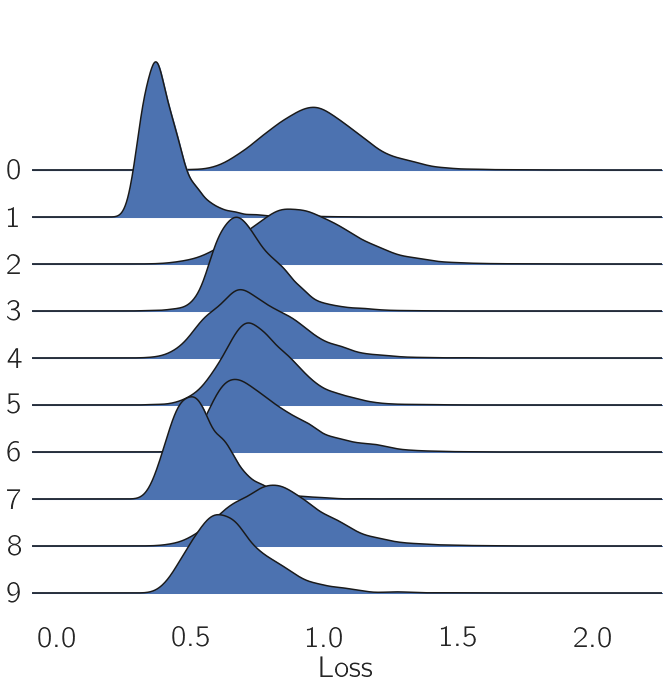

In [166]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rc

rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('text', usetex=True)
sns.set_theme()
sns.set(font_scale=2.5, style="whitegrid")

from joypy import joyplot

#targets = public_data.dataset.targets[public_data.indices].numpy()

df = pd.DataFrame(out_data, columns=['h_x', 'h_y', 'y_true', 'loss'])

# sns.displot(df, x='loss', hue='y_true', kind='kde')

fig, ax = joyplot(data=df[['loss', 'y_true']], by='y_true', figsize=(10, 10))
plt.xlabel('Loss')
plt.show()

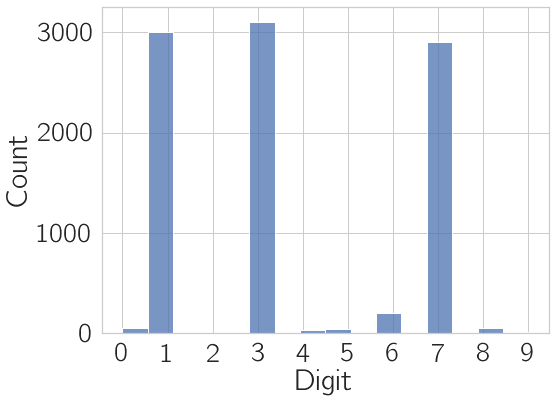

In [167]:
digits = []

for i, n in enumerate(dist):
    digits.extend([i] * n)

fig, ax = plt.subplots(1, figsize=(8, 6))
sns.histplot(ax=ax, data=digits)
ax.set_xlabel('Digit')
ax.set_xticks(np.arange(10))
plt.show()

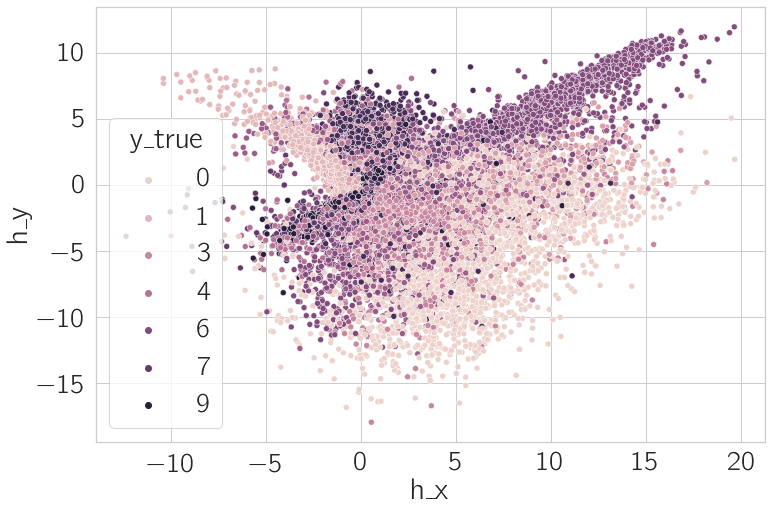

In [171]:
fig, ax = plt.subplots(1, figsize=(12, 8))
# df['h_x'] = df['h_x'].apply(lambda x: x[0])
# df['h_y'] = df['h_y'].apply(lambda x: x[0])
sns.scatterplot(ax=ax, data=df, x='h_x', y='h_y', hue='y_true')
plt.show()